In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

In [2]:
# 시퀀스 데이터 생성 함수
def to_sequences(x, seq_size=1):
    x_values = []
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
    return np.array(x_values)


In [3]:
# sns.lineplot(x=df['Date'], y=df['brake_value'])

In [4]:
# sns.lineplot(x=df['Date'], y=df['shift_speed'])

In [5]:
# sns.lineplot(x=df['Date'], y=df['accel_value'])

In [6]:
dataframe = pd.read_csv('C:\\Users\\jinho\\Desktop\\Taba_AI\\dataset\\0510_brake.csv')

# 이전 값을 빼고 min max scaling
dataframe['shift_speed'] = dataframe['speed'] - dataframe['speed'].shift(1)
dataframe['shift_speed'].fillna(0, inplace = True)

min_shift_speed = min(dataframe['shift_speed'])
max_shift_speed = max(dataframe['shift_speed'])

normalization_speed_df = (dataframe['shift_speed'] - min_shift_speed) / (max_shift_speed - min_shift_speed)

dataframe['normalize_speed'] = normalization_speed_df
dataframe.head()

df = dataframe[['accel_value', 'brake_value', 'shift_speed',  'Date']]

C:\Users\jinho\AppData\Local\Temp\ipykernel_11860\2664189962.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataframe['shift_speed'].fillna(0, inplace = True)


In [7]:
count = df['accel_value'].count()
train = df.iloc[:int(count*0.8)]
test = df.iloc[int(count*0.8):]

# 데이터 정규화
scaler = MinMaxScaler()
scaler = scaler.fit(train[['accel_value', 'brake_value', 'shift_speed']])

train[['accel_value','brake_value', 'shift_speed']] = scaler.transform(train[['accel_value','brake_value', 'shift_speed']])
test[['accel_value','brake_value', 'shift_speed']] = scaler.transform(test[['accel_value','brake_value', 'shift_speed']])

C:\Users\jinho\AppData\Local\Temp\ipykernel_11860\916032159.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['accel_value','brake_value', 'shift_speed']] = scaler.transform(train[['accel_value','brake_value', 'shift_speed']])
C:\Users\jinho\AppData\Local\Temp\ipykernel_11860\916032159.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['accel_value','brake_value', 'shift_speed']] = scaler.transform(test[['accel_value','brake_value', 'shift_speed']])


In [8]:
seq_size = 30  # Number of time steps to look back

trainX = to_sequences(train[['accel_value', 'brake_value', 'shift_speed']], seq_size)
testX = to_sequences(test[['accel_value', 'brake_value', 'shift_speed']], seq_size)

# 예측 값은 시퀀스의 마지막 값으로 설정
trainY = train[['accel_value', 'brake_value', 'shift_speed']].iloc[seq_size:].values
testY = test[['accel_value', 'brake_value', 'shift_speed']].iloc[seq_size:].values

In [9]:
# # 모델 정의
# model = Sequential()
# model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(rate=0.2))
# # RepeatVector 층 제거 - 시퀀스-투-벡터 모델링에 적합
# model.add(Dense(trainY.shape[1]))  # trainY.shape[1] == 3, 출력 차원을 trainY와 일치시킴
# model.compile(optimizer='adam', loss='mae')
# model.summary()

In [10]:
# # 모델 학습
# history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

In [11]:
from keras.metrics import MeanAbsoluteError
# 사용자 정의 메트릭을 custom_objects로 제공
model = keras.models.load_model(
    'C:\\Users\\jinho\\Desktop\\Taba_AI\\taba_model.h5',
    custom_objects={'mae': MeanAbsoluteError()}
)

print(model.summary())

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 128)                 │          67,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,973 (265.52 KB)

 Trainable params: 67,971 (265.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [35]:
sample = np.expand_dims(testX[0], axis=0)
# 예측
prediction = model.predict(sample)
testMAE = np.mean(np.abs(prediction - testY[0]), axis=1)
print(testMAE)
print("y:", testY[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.03937742]
y: [0.16492147 0.00512821 0.375     ]


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


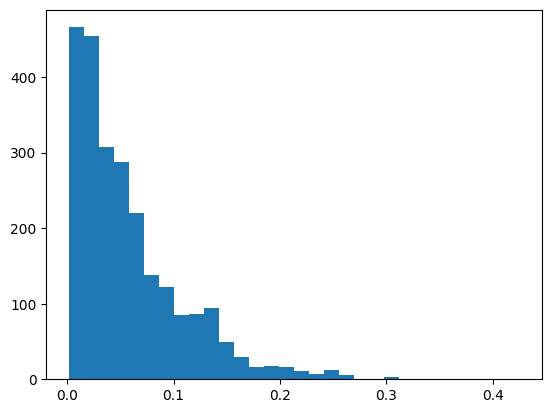

0.4252552301949038
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


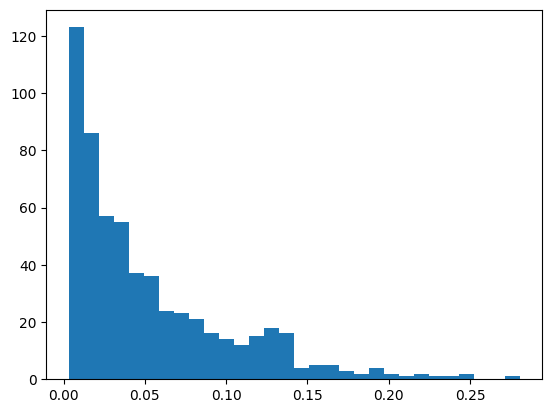

In [12]:
# 모델 평가 및 이상치 탐지
trainPredict = model.predict(trainX)
# trainY와 예측값의 차이 계산
trainMAE = np.mean(np.abs(trainPredict - trainY), axis=1)
plt.hist(trainMAE, bins=30)
plt.show()
print(max(trainMAE))
# trainMAE = 0.4252552301949038

max_trainMAE = max(trainMAE) * 0.8  # 또는 최대값의 90%를 임계값으로 정의.
testPredict = model.predict(testX)
# testY와 예측값의 차이 계산
testMAE = np.mean(np.abs(testPredict - testY), axis=1)
plt.hist(testMAE, bins=30)
plt.show()

In [13]:
# Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df[['shift_speed', 'accel_value', 'brake_value']] = test[seq_size:][['shift_speed', 'accel_value', 'brake_value']]

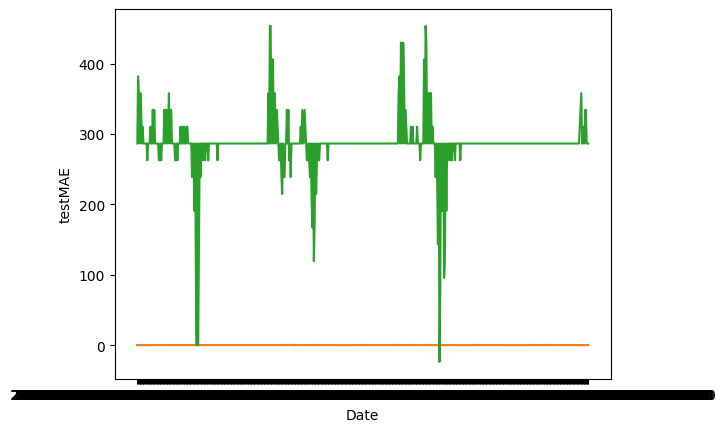

In [14]:
# Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]


# Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df[['shift_speed', 'accel_value', 'brake_value']])[:, 0])

if not anomalies.empty:
    sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies[['shift_speed', 'accel_value', 'brake_value']])[:, 0], color='r')

In [15]:
print(anomalies)

Empty DataFrame
Columns: [accel_value, brake_value, shift_speed, Date, testMAE, max_trainMAE, anomaly]
Index: []
